# Battle of the Neighborhoods - Week 4 & 5

## Table of contents
* [Introduction/Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction/Problem <a name="introduction"></a>

Many big corporation will have times when they need to relocate an employee from one country to another country as part of international assignment. Relocating the employee and their family can be a tricky task if it is not managed correctly. The family may not feel settled in the new area. The international assignment department which handles this can provide recommendation of areas where employees can stay in the new location with a view that it may help alleviate some of the concerns. These recommendations are based on past experiences they have which may be a sound approach. However, such recommendation may not suit all employees. **How can the department provide more useful recommendations of where to live?** One way is to use the employee's current dwelling location and use that as a **basis of comparison** in recommending neighborhoods with similar characteristics.

For this assignment, we will attempt to find out neighborhoods in another city which is similar to the location that an employee is currently living. This report will be targeted to **stakeholders within the international assignment department and also the employee due to relocate.** 

The following scenario has been developed for the purpose of this assignment. 

Imagine John Doe, a Microsoft employee who has worked in London, UK for a long time, has recently been reassigned to San Francisco, California in the United States. Due to the reassignment, John Doe and his family will be relocating to San Francisco. John Doe has a specific requirement to stay in an area in San Francisco that is similar to where their family is staying now in London. John Doe currently stays near the Richmond Underground tube station and the Microsoft Headquarters in San Francisco is at 555 California St 200, San Francisco, CA 94104, United States. John Doe would also like to stay somewhere close to the new office. **The international assignment department now has to provide a list of recommended neighborhoods in San Francisco for John Doe.**

## Data <a name="data"></a>

Every individual has specific requirements when choosing an area to live in. This can be school rating, venues available around the area, housing prices, availability of houses to buy/rent, crime data and etc.

For this assignment, we will be looking at venues around the area and will use the following data:

**1. Neighborhood data for San Francisco**

This is obtained using the geojson data in the following the link: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4. The geojson data has the name of the neighborhood and the geometry of the neighborhood. We will use the geometry to find the centroid which will then be used to find nearby venues.

**2. Foursquare API Venues data**

The Foursquare venues data will be used to identify venues within a certain area of a location. We will be interested in the venue categories for neighborhoods within San Francisco and near Richmond underground station. Venue categories is a good way of characterising a particular location. There maybe different nomenclature of between Richmond, UK and San Francisco neighborhoods which we will have to make common to ensure appropriate clustering.

**3. Geodata**

We will be using Geopy to identify the geodata for Richmond Underground Station, the new workplace and the distance between the neighborhoods and the new workplace.

## Methodology <a name="methodology"></a>

Based on the scenario created above, the plan of action is as follows:
1. Obtain location of Richmond Underground Station and explore the area within 500m of the station
2. Obtain location of neighborhoods for San Francisco.
3. Explore each neighborhoods and add the explored data from Richmond.
4. Cluster the neighborhoods and highlight which San Francisco cluster is similar to Richmond.
5. Within that cluster, sort neighborhoods by distance to Microsoft Headquarters.

## Analysis <a name="analysis"></a>

First let import all the relevant libraries that will be required.

### Import all the relevant libraries

In [1]:
# import pandas library for data analysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import json
import json

#import Polygon from shapely to compute centroid
from shapely.geometry import Polygon

# import library to handle requests
import requests

# tranform JSON file into a pandas dataframe
from pandas import json_normalize

# import numpy
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import folium for generating map
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance

# import os.path
import os.path

# confirm that all libraries have been imported
print('Libraries imported!')

Libraries imported!


### Obtain long-lat of Richmond Underground Station, UK

Let's use geopy to obtain latitudes and longitudes of Richmond underground station, which has the following address: The Quadrant, Richmond TW9 1EZ. The address is obtained from Google Search.

In [2]:
geolocator = Nominatim(user_agent="My_IBM_Week_4_Submission")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
# use geopy to get geocode for the location
location = geolocator.geocode("The Quadrant, Richmond TW9 1EZ")
rich_long = location.longitude
rich_lat = location.latitude
print("Richmond Underground Station is located at {} with latitude of {} and longitude of {}.".format(location.address,
                                                                                                     rich_lat,rich_long))

Richmond Underground Station is located at The Quadrant, Petersham, London Borough of Richmond upon Thames, London, Greater London, England, TW9 1DJ, United Kingdom with latitude of 51.4623107 and longitude of -0.3027858.


### Set user ID for Foursquare API

In [3]:
# @hidden_cell
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '27052020' # Foursquare API version

### Exploring around Richmond Underground Station

Let's explore 500m around Richmond and see what results we get.

In [4]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},\
{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, rich_lat, rich_long, VERSION, radius, LIMIT)
results = requests.get(url).json()
print('Results obtained!')

Results obtained!


Borrowing the get category function from earlier assignments.

In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's clean and restructure json data into a dataframe.

In [6]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Butter Beans,Coffee Shop,51.463590,-0.301869
1,Kiss the Hippo Coffee,Coffee Shop,51.460919,-0.304230
2,Richmond Green,Park,51.461250,-0.305918
3,Richmond Theatre,Theater,51.462130,-0.304009
4,Digme Fitness,Cycle Studio,51.461212,-0.301726


Let's find out how many venues were returned in the dataframe?

In [7]:
print('{} venues were returned by Foursquare around Richmond'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare around Richmond


That's the maximum amount that Fourquare allows us to get under the venue recommendation API. Let's explore how many unique categories there are in the area.

In [8]:
print('{} unique venue categories were returned by Foursquare around Richmond'.format(len(nearby_venues.categories.unique())))

51 unique venue categories were returned by Foursquare around Richmond


Let's see what the unique venue categories are

In [9]:
nearby_venues[['categories','name']].groupby('categories').agg('count').sort_values(by='name',ascending=False).head(10)

,name
categories,
Pub,15
Coffee Shop,7
Italian Restaurant,6
Café,6
Bakery,4
Grocery Store,4
Restaurant,3
Women's Store,2
Sandwich Place,2


Seems like within 500m of the Richmond underground station, there is a high concentration of pubs, Italian Restaurants and coffee shops. Let's add Richmond in as a neighborhood along with latitude and longitudes as we will use this information later.

In [10]:
nearby_venues['Neighborhood']='Richmond'
nearby_venues['Neighborhood Latitude']=rich_lat
nearby_venues['Neighborhood Longitude']=rich_long
# rename columns and rearrange
nearby_venues.rename(columns={'name':'Venue','categories':'Venue Category','lat':'Venue Latitude','lng':'Venue Longitude'},
                    inplace=True)
arranged_columns = list(nearby_venues.columns[-3:])+list(nearby_venues.columns[:-3])
nearby_venues=nearby_venues[arranged_columns]
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Richmond,51.462311,-0.302786,Butter Beans,Coffee Shop,51.463590,-0.301869
1,Richmond,51.462311,-0.302786,Kiss the Hippo Coffee,Coffee Shop,51.460919,-0.304230
2,Richmond,51.462311,-0.302786,Richmond Green,Park,51.461250,-0.305918
3,Richmond,51.462311,-0.302786,Richmond Theatre,Theater,51.462130,-0.304009
4,Richmond,51.462311,-0.302786,Digme Fitness,Cycle Studio,51.461212,-0.301726


### Let's get all the neighborhoods in San Francisco

Importing the San Franscisco neighborhoods geojson file from https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4 and storing it locally.

In [11]:
url = 'https://data.sfgov.org/api/geospatial/pty2-tcw4?method=export&format=GeoJSON'
r = requests.get(url, allow_redirects=True)

open('sanfran_data.geojson', 'wb').write(r.content)
print('File Downloaded and Stored!')

File Downloaded and Stored!


### Initialize dataframe, obtain data from geojson and iterate

Open the file and read through the geojson and place in a dataframe

In [12]:
# Initialize dataframe with a set column header names
column_header = ["Neighborhood","Latitude","Longitude"]
df = pd.DataFrame(columns = column_header)
df

# open geojson and load data
with open('sanfran_data.geojson') as geojson_data:
    sanfran_data = json.load(geojson_data)

# iterate across features to obtain neighborhood name and 
for neigh in sanfran_data['features']:
    neigh_name = neigh['properties']['name']
    neigh_polygon = Polygon(neigh['geometry']['coordinates'][0][0])
    neigh_lat = float(neigh_polygon.centroid.wkt.split()[2].rstrip(')'))
    neigh_long = float(neigh_polygon.centroid.wkt.split()[1].lstrip('('))
    df = df.append({'Neighborhood':neigh_name,'Latitude':neigh_lat,'Longitude':neigh_long},ignore_index=True)
df.sort_values(by='Neighborhood',inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.776348,-122.434688
1,Anza Vista,37.780957,-122.443228
2,Apparel City,37.739438,-122.404560
3,Aquatic Park / Ft. Mason,37.805949,-122.427025
4,Ashbury Heights,37.762516,-122.449097


Let's check how many neighborhoods are in San Francisco?

In [13]:
print(len(df),'neighborhoods in San Francisco')

117 neighborhoods in San Francisco


Now that we have a complete set of geocodes, let's draw up all 117 neighborhoods in folium. We'll need to get the San Francisco location first.

In [14]:
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="My_IBM_Week_4_Submission")
sanfran_location = geolocator.geocode(address,country_codes="us",exactly_one=True,viewbox=[(37.82,-122.53),(37.68,-122.34)])
sanfran_latitude = sanfran_location.latitude
sanfran_longitude = sanfran_location.longitude
print('The geograpical coordinate of San Francisco, CA are {}, {}.'.format(sanfran_latitude, sanfran_longitude))

The geograpical coordinate of San Francisco, CA are 37.7790262, -122.4199061.


## Creating folium map of San Francisco, CA

In [15]:
# create map of San Francisco using latitude and longitude values
map_sanfran = folium.Map(location=[sanfran_latitude, sanfran_longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    if pd.isna(lat)==False:
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.5,
            
        parse_html=False).add_to(map_sanfran)  
    
map_sanfran

### Time to explore the San Francisco neighborhoods

Borrowing function from earlier labs to find venues for all neighborhoods in San Francisco. We'll use the same radius as we did for Richmond, 500m.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},\
        {}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
                    
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])
                    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Use above defined function and run it for all neighborhoods in San Francisco and put it to *san_fran_venues*. We will store the obtained values in a local csv for future use. If the file does not exist, we will request from Foursquare, if not we will load from local csv.

In [17]:
if os.path.isfile('./san_fran_venues.csv')==False:
    san_fran_venues = getNearbyVenues(names=df['Neighborhood'],
                                      latitudes=df['Latitude'],
                                      longitudes=df['Longitude']
                                      )
    print('Complete!')
    san_fran_venues.to_csv('san_fran_venues.csv')
else:
    print('File exists!')
    san_fran_venues = pd.read_csv('san_fran_venues.csv')[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude',
                 'Venue Category']]

File exists!


Now let's checking the size of the resulting dataframe

In [18]:
print(san_fran_venues.shape)
san_fran_venues.head()

(4632, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alamo Square,37.776348,-122.434688,Alamo Square,37.776045,-122.434363,Park
1,Alamo Square,37.776348,-122.434688,Alamo Square Dog Park,37.775878,-122.435740,Dog Run
2,Alamo Square,37.776348,-122.434688,Painted Ladies,37.776120,-122.433389,Historic Site
3,Alamo Square,37.776348,-122.434688,The Independent,37.775573,-122.437835,Rock Club
4,Alamo Square,37.776348,-122.434688,The Mill,37.776425,-122.437970,Bakery


Let's group the venues by neighborhood to check how many venues are found per neighborhood

In [19]:
print(san_fran_venues.groupby('Neighborhood').count().shape)
san_fran_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue',ascending=False).head(10)

(117, 6)


,Venue
Neighborhood,
Fishermans Wharf,100
Tenderloin,100
Haight Ashbury,100
Chinatown,100
Hayes Valley,100
Downtown / Union Square,100
Mission Dolores,98
Marina,98
Lower Nob Hill,96


Which neighborhood has the least venues found?

In [20]:
san_fran_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue',ascending=True).head(10)

,Venue
Neighborhood,
Hunters Point,3
Monterey Heights,3
McLaren Park,4
Lakeshore,4
University Mound,4
Presidio National Park,4
Sunnydale,5
Midtown Terrace,5
Seacliff,5


Investigate how many unique categories there are from all returned values

In [21]:
print('There are {} unique categories.'.format(len(san_fran_venues['Venue Category'].unique())))

There are 368 unique categories.


How about comparing against Richmond? How many unique categories will be returned. Let's use Fishermans Wharf as it returned 100 venues

In [22]:
fishermans =  san_fran_venues[san_fran_venues['Neighborhood']=='Fishermans Wharf']
print('There are {} unique categories.'.format(len(fishermans['Venue Category'].unique())))

There are 55 unique categories.


 Let's use Tenderloin as it returned 100 venues as well

In [23]:
tenderloin =  san_fran_venues[san_fran_venues['Neighborhood']=='Tenderloin']
print('There are {} unique categories.'.format(len(tenderloin['Venue Category'].unique())))

There are 54 unique categories.


That is comparable to Richmond. So the 368 unique categories is sound. Let's check what the unique categories are and the count.

In [24]:
san_fran_venues[['Venue Category','Neighborhood']].groupby('Venue Category').agg('count').sort_values(
    by='Neighborhood',ascending=False).head(10)

,Neighborhood
Venue Category,
Coffee Shop,187
Café,143
Park,134
Pizza Place,94
Bakery,91
Grocery Store,79
Chinese Restaurant,77
Italian Restaurant,77
Mexican Restaurant,75


There's a high proportion of coffee shops, cafes, parks, and pizza place. Let's find out the number of San Francisco's unique venue category that is in the Richmond's unique venue category.

In [25]:
# initialize empty variables
ven_cat_sum = 0
ven_cat_list = []
# iterate through San Fran's unique values and check if it is in Richmond's unique values
for ven_cat in san_fran_venues['Venue Category'].unique():
    if ven_cat in nearby_venues['Venue Category'].unique():
        ven_cat_sum = ven_cat_sum + 1
        ven_cat_list.append(ven_cat)
print(ven_cat_sum, "San Francisco unique venue category are in Richmond's overall",
      len(nearby_venues['Venue Category'].unique()),'unique venue category.\n')
print(ven_cat_list)

48 San Francisco unique venue category are in Richmond's overall 51 unique venue category.

['Park', 'Bakery', 'Seafood Restaurant', 'Gift Shop', 'Ice Cream Shop', 'Pizza Place', 'Cocktail Bar', 'Farmers Market', 'Sushi Restaurant', 'Italian Restaurant', 'Spanish Restaurant', 'Burrito Place', 'Comic Shop', 'Restaurant', 'Café', 'Coffee Shop', 'Grocery Store', 'Convenience Store', 'Burger Joint', 'Sandwich Place', 'Juice Bar', 'Athletics & Sports', 'Chocolate Shop', 'Bookstore', 'Pharmacy', 'Theater', "Women's Store", 'Dessert Shop', 'Thai Restaurant', 'Plaza', 'Asian Restaurant', 'Bus Stop', 'Gastropub', 'Cycle Studio', 'Deli / Bodega', 'Supermarket', 'Japanese Restaurant', 'Clothing Store', 'Beer Bar', 'French Restaurant', 'Tapas Restaurant', 'Movie Theater', 'Mobile Phone Shop', 'Argentinian Restaurant', 'Pool', 'Pub', 'Train Station', 'Portuguese Restaurant']


Let's filter our the San Francisco venues dataframe with only that 49 unique categories and see how many venues are left.

In [26]:
san_fran_filtered = san_fran_venues[san_fran_venues['Venue Category'].isin(ven_cat_list)]
print('There are only',san_fran_filtered.shape[0],'venues found compared to the overall venues',
      san_fran_venues.shape[0],'venues.')

There are only 1771 venues found compared to the overall venues 4632 venues.


Do all neighborhoods in San Francisco have at least one of those 49 unique venue categories?

In [27]:
print(len(san_fran_venues['Neighborhood'].unique())-len(san_fran_filtered['Neighborhood'].unique()), 'neighborhoods does not \
have any of the 49 unique venue categories')

4 neighborhoods does not have any of the 49 unique venue categories


In [28]:
print(san_fran_venues['Neighborhood'][~san_fran_venues['Neighborhood'].isin(san_fran_filtered['Neighborhood'])].unique())

['Hunters Point' 'Midtown Terrace' 'Monterey Heights' 'Seacliff']


Out of the overall San Francisco venues, just under half of those are in the same venue categories as those found in Richmond. This may be positive in the fact that there is a difference between the San Francisco neighborhoods and Richmond neighborhood and clustering will be distinctive. However, there difference maybe due to incorrect labelling or adjacencies for example a cocktail bar or beer bar, can be considered to be the same as pubs. They maybe collectively relabelled as 'bars' to reduce the dimensionality. On the plus side, 49 out 53 unique venue categories exist in San Francisco. That means Richmond can be clustered somewhere within San Francisco. We will also expect Richmond not to be clustered with Hunters Point, Midtown Terrace, Monterey Heights and Seacliff.

### Adding Richmond into dataframe before clustering

Now that we have the venues data for San Francisco, let's append the data from Richmond before clustering. This will allow the clustering algorithm to fit Richmond amongst the cluster of neighborhoods in San Franscisco that is closest in characteristics.

In [29]:
san_fran_rich_venues = nearby_venues.append(san_fran_venues,ignore_index=True)
san_fran_rich_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Richmond,51.462311,-0.302786,Butter Beans,Coffee Shop,51.463590,-0.301869
1,Richmond,51.462311,-0.302786,Kiss the Hippo Coffee,Coffee Shop,51.460919,-0.304230
2,Richmond,51.462311,-0.302786,Richmond Green,Park,51.461250,-0.305918
3,Richmond,51.462311,-0.302786,Richmond Theatre,Theater,51.462130,-0.304009
4,Richmond,51.462311,-0.302786,Digme Fitness,Cycle Studio,51.461212,-0.301726


Let's check the size of the dataframe now.

In [30]:
san_fran_rich_venues.shape

(4732, 7)

### Prepping data for clustering through one-hot encoding

Now let's conduct one hot encoding on the venue categories and re-associate it with the corresponding neighborhood.

In [31]:
# one hot encoding
san_fran_onehot = pd.get_dummies(san_fran_rich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
san_fran_onehot['Neighborhood'] = san_fran_rich_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(san_fran_onehot)
fixed_columns.insert(0,fixed_columns.pop(fixed_columns.index('Neighborhood')))
san_fran_onehot = san_fran_onehot[fixed_columns]

san_fran_onehot.head()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laboratory,Lake,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nabe Restaurant,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apa

In [32]:
# checking the tail end of the dataframe
san_fran_onehot.tail()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laboratory,Lake,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nabe Restaurant,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apa

Now let's group them by the neighborhood to get an idea of the mean of venue occurences in each category

In [33]:
san_fran_grouped = san_fran_onehot.groupby('Neighborhood').mean().reset_index()
san_fran_grouped.head()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laboratory,Lake,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nabe Restaurant,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apa

Let's check the shape of the dataframe

In [34]:
san_fran_grouped.shape

(118, 371)

Borrowing function to rate the top location for each neighborhood

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now to create a dataframe of neighborhoods with the top 15 most common venue categories

In [36]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
# match new dataframe 'Neighborhood' column with the san_fran_grouped dataframe
neighborhoods_venues_sorted['Neighborhood'] = san_fran_grouped['Neighborhood']

for ind in np.arange(san_fran_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(san_fran_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(118, 16)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Alamo Square,Bar,Seafood Restaurant,Sushi Restaurant,Café,Hotel,Pizza Place,Liquor Store,Wine Bar,Record Shop,Ethiopian Restaurant,New American Restaurant,Grocery Store,Comic Shop,Coffee Shop,Rock Club
1,Anza Vista,Café,Burger Joint,Tunnel,Coffee Shop,Big Box Store,Sandwich Place,Electronics Store,Juice Bar,Mexican Restaurant,Cosmetics Shop,Health & Beauty Service,Grocery Store,Arts & Crafts Store,Field,Filipino Restaurant
2,Apparel City,Arts & Crafts Store,Nightclub,Brewery,Furniture / Home Store,Miscellaneous Shop,Garden Center,Gas Station,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Outdoor Supply Store,Paintball Field,Food Truck,Hardware Store,Automotive Shop
3,Aquatic Park / Ft. Mason,Art Gallery,Chocolate Shop,Food Truck,Theater,Scenic Lookout,Café,National Park,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Gift Shop,Park,German Restaurant,Mini Golf,Beer Garden,Garden
4,Ashbury Heights,Park,Breakfast Spot,Wine Bar,Coffee Shop,Garden,Snack Place,Bar,Light Rail Station,Gift Shop,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Bus Line


## Now time to cluster them

Determining the best k-value for clustering

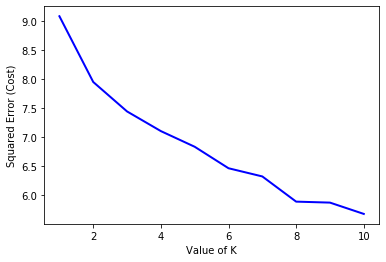

In [37]:
cost = []
san_fran_grouped_clustering = san_fran_grouped.drop('Neighborhood', 1)
for i in range(1,11):
    KM = KMeans(n_clusters = i, random_state=0, max_iter=500).fit(san_fran_grouped_clustering)
    
    # calculate squared error for clustered points
    cost.append(KM.inertia_)
    
# plot cost against K values
plt.plot(range(1,11),cost,color='b',linewidth='2')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

Point of elbow is when k=8. Run k-means to cluster the neighborhood into 8 clusters.

In [38]:
# set number of clusters
kclusters = 8

san_fran_grouped_clustering = san_fran_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(san_fran_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 6, 4, 6, 4, 1, 1, 1, 2, 4, 1, 0,
       1, 1, 1, 0, 1, 4, 1, 1, 0, 1, 1, 1, 1, 1, 4, 0, 1, 5, 1, 4, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       4, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1])

Now lets combine the cluster labels with the top 15 venues

In [39]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except: 
    neighborhoods_venues_sorted
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,1,Alamo Square,Bar,Seafood Restaurant,Sushi Restaurant,Café,Hotel,Pizza Place,Liquor Store,Wine Bar,Record Shop,Ethiopian Restaurant,New American Restaurant,Grocery Store,Comic Shop,Coffee Shop,Rock Club
1,1,Anza Vista,Café,Burger Joint,Tunnel,Coffee Shop,Big Box Store,Sandwich Place,Electronics Store,Juice Bar,Mexican Restaurant,Cosmetics Shop,Health & Beauty Service,Grocery Store,Arts & Crafts Store,Field,Filipino Restaurant
2,1,Apparel City,Arts & Crafts Store,Nightclub,Brewery,Furniture / Home Store,Miscellaneous Shop,Garden Center,Gas Station,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Outdoor Supply Store,Paintball Field,Food Truck,Hardware Store,Automotive Shop
3,1,Aquatic Park / Ft. Mason,Art Gallery,Chocolate Shop,Food Truck,Theater,Scenic Lookout,Café,National Park,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Gift Shop,Park,German Restaurant,Mini Golf,Beer Garden,Garden
4,1,Ashbury Heights,Park,Breakfast Spot,Wine Bar,Coffee Shop,Garden,Snack Place,Bar,Light Rail Station,Gift Shop,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Bus Line


Now let's find out which cluster is Richmond in

In [40]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood']=='Richmond']

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
91,1,Richmond,Pub,Coffee Shop,Café,Italian Restaurant,Bakery,Grocery Store,Restaurant,Thai Restaurant,Clothing Store,Pizza Place,French Restaurant,Sushi Restaurant,Burger Joint,Sandwich Place,Bus Stop


Let's check out that the cluster that Richmond is in

In [41]:
cluster_no = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Richmond',
                                             ['Cluster Labels']].values[0][0]
print('Richmond is in cluster',cluster_no)
cluster_neigh = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==cluster_no]
print('There are {} neighborhoods in San Francisco that is similar to Richmond'.format(cluster_neigh.shape[0]-1))

Richmond is in cluster 1
There are 80 neighborhoods in San Francisco that is similar to Richmond


Let's filter out the relevant cluster neighborhoods and drop Richmond

In [42]:
cluster_neigh = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==cluster_no]
cluster_neigh = cluster_neigh[cluster_neigh.Neighborhood != 'Richmond']
cluster_neigh.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,1,Alamo Square,Bar,Seafood Restaurant,Sushi Restaurant,Café,Hotel,Pizza Place,Liquor Store,Wine Bar,Record Shop,Ethiopian Restaurant,New American Restaurant,Grocery Store,Comic Shop,Coffee Shop,Rock Club
1,1,Anza Vista,Café,Burger Joint,Tunnel,Coffee Shop,Big Box Store,Sandwich Place,Electronics Store,Juice Bar,Mexican Restaurant,Cosmetics Shop,Health & Beauty Service,Grocery Store,Arts & Crafts Store,Field,Filipino Restaurant
2,1,Apparel City,Arts & Crafts Store,Nightclub,Brewery,Furniture / Home Store,Miscellaneous Shop,Garden Center,Gas Station,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Outdoor Supply Store,Paintball Field,Food Truck,Hardware Store,Automotive Shop
3,1,Aquatic Park / Ft. Mason,Art Gallery,Chocolate Shop,Food Truck,Theater,Scenic Lookout,Café,National Park,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Gift Shop,Park,German Restaurant,Mini Golf,Beer Garden,Garden
4,1,Ashbury Heights,Park,Breakfast Spot,Wine Bar,Coffee Shop,Garden,Snack Place,Bar,Light Rail Station,Gift Shop,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Bus Line


Let's check if Hunters Point, Midtown Terrace, Monterey Heights or Seacliff is in the cluster

In [43]:
[print(i) for i in cluster_neigh['Neighborhood'] if i in ['Hunters Point', 'Midtown Terrace', 'Monterey Heights','Seacliff']]

[]

The list is empty so we know Hunters Point, Midtown Terrace, Monterey Heights and Seacliff are not in the cluster as expected. Let's merge cluster with San Francisco dataframe with geo data so that we can visualise them in folium later

In [44]:
# merge cluster with df data to add latitude/longitude for each neighborhood
cluster_merged = df.join(cluster_neigh.set_index('Neighborhood'), on='Neighborhood',how='right')
cluster_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Alamo Square,37.776348,-122.434688,1,Bar,Seafood Restaurant,Sushi Restaurant,Café,Hotel,Pizza Place,Liquor Store,Wine Bar,Record Shop,Ethiopian Restaurant,New American Restaurant,Grocery Store,Comic Shop,Coffee Shop,Rock Club
1,Anza Vista,37.780957,-122.443228,1,Café,Burger Joint,Tunnel,Coffee Shop,Big Box Store,Sandwich Place,Electronics Store,Juice Bar,Mexican Restaurant,Cosmetics Shop,Health & Beauty Service,Grocery Store,Arts & Crafts Store,Field,Filipino Restaurant
2,Apparel City,37.739438,-122.404560,1,Arts & Crafts Store,Nightclub,Brewery,Furniture / Home Store,Miscellaneous Shop,Garden Center,Gas Station,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Outdoor Supply Store,Paintball Field,Food Truck,Hardware Store,Automotive Shop
3,Aquatic Park / Ft. Mason,37.805949,-122.427025,1,Art Gallery,Chocolate Shop,Food Truck,Theater,Scenic Lookout,Café,National Park,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Gift Shop,Park,German Restaurant,Mini Golf,Beer Garden,Garden
4,Ashbury Heights,37.762516,-122.449097,1,Park,Breakfast Spot,Wine Bar,Coffee Shop,Garden,Snack Place,Bar,Light Rail Station,Gift Shop,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Bus Line


Checking to make sure the merge is correct

In [45]:
if (cluster_neigh.shape[0] == cluster_merged.shape[0])==True: print('Merge is correct')

Merge is correct


### Calculating distance between each neighborhood to Microsoft Headquarters

Now let's get the latitude and longitudes for the Microsoft Headquarters in San Francisco (555 California St 200, San Francisco, CA 94104, United States)

In [46]:
microsoft_address = '555 California St, San Francisco, CA 94104, United States'

geolocator = Nominatim(user_agent="My_IBM_Week_4_Submission")
microsoft_location = geolocator.geocode(microsoft_address,country_codes="us",
                                        exactly_one=True,viewbox=[(37.82,-122.53),(37.68,-122.34)])
microsoft_latitude = microsoft_location.latitude
microsoft_longitude = microsoft_location.longitude
print('The geograpical coordinate of 555 California St 200, San Francisco, CA 94104, \
United States are {}, {}.'.format(microsoft_latitude, microsoft_longitude))

The geograpical coordinate of 555 California St 200, San Francisco, CA 94104, United States are 37.792548350000004, -122.4042699625.


To calculate distance between two points, I will use geopy's distance class. Below is an example using Alamo Square.

In [47]:
# first lets put the microsoft geodata in a tuple
microsoft_lat_long = (microsoft_latitude, microsoft_longitude)
print('Microsoft lat-long is', microsoft_lat_long)

# now let put Alamo Square geodata in a tuple
alamo_lat_long = (cluster_merged.at[0,'Latitude'],cluster_merged.at[0,'Longitude'])
print('Alamo Square lat-long is', alamo_lat_long)

print('Distance between Microsoft Headquarters and Alamo Square is',distance.distance(microsoft_lat_long,alamo_lat_long).miles,
     'miles')

Microsoft lat-long is (37.792548350000004, -122.4042699625)
Alamo Square lat-long is (37.77634772241759, -122.4346882823427)
Distance between Microsoft Headquarters and Alamo Square is 2.0051276325616105 miles


Now let's do that for neighborhood and add it to the cluster_merged dataframe

In [48]:
# reset index on cluster_merged
cluster_merged.reset_index(drop=True,inplace=True)
cluster_merged['Distance from Microsoft'] = None
# iterate across each row, calculate distance and add data to each row
for neigh, lat, long in zip(cluster_merged.Neighborhood, cluster_merged.Latitude,cluster_merged.Longitude):
    neigh_lat_long = (lat,long)
    neigh_distance = distance.distance(microsoft_lat_long,neigh_lat_long).miles
    cluster_merged.loc[cluster_merged['Neighborhood']==neigh,['Distance from Microsoft']] = neigh_distance
cluster_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,Distance from Microsoft
0,Alamo Square,37.776348,-122.434688,1,Bar,Seafood Restaurant,Sushi Restaurant,Café,Hotel,Pizza Place,Liquor Store,Wine Bar,Record Shop,Ethiopian Restaurant,New American Restaurant,Grocery Store,Comic Shop,Coffee Shop,Rock Club,2.00513
1,Anza Vista,37.780957,-122.443228,1,Café,Burger Joint,Tunnel,Coffee Shop,Big Box Store,Sandwich Place,Electronics Store,Juice Bar,Mexican Restaurant,Cosmetics Shop,Health & Beauty Service,Grocery Store,Arts & Crafts Store,Field,Filipino Restaurant,2.27727
2,Apparel City,37.739438,-122.404560,1,Arts & Crafts Store,Nightclub,Brewery,Furniture / Home Store,Miscellaneous Shop,Garden Center,Gas Station,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Outdoor Supply Store,Paintball Field,Food Truck,Hardware Store,Automotive Shop,3.66291
3,Aquatic Park / Ft. Mason,37.805949,-122.427025,1,Art Gallery,Chocolate Shop,Food Truck,Theater,Scenic Lookout,Café,National Park,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Gift Shop,Park,German Restaurant,Mini Golf,Beer Garden,Garden,1.55076
4,Ashbury Heights,37.762516,-122.449097,1,Park,Breakfast Spot,Wine Bar,Coffee Shop,Garden,Snack Place,Bar,Light Rail Station,Gift Shop,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Bus Line,3.21117


Now let's show the dataframe in fewer columns

In [49]:
# reduce the columns in the dataframe
fixed_columns = ['Neighborhood','Latitude','Longitude','Distance from Microsoft']
cluster_fixed = cluster_merged[fixed_columns]
# round the distance column
cluster_fixed['Distance from Microsoft'] = cluster_fixed['Distance from Microsoft'].apply(lambda x: round(x,2))
cluster_fixed.head(15)

C:\Users\chiew\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Neighborhood,Latitude,Longitude,Distance from Microsoft
0,Alamo Square,37.776348,-122.434688,2.01
1,Anza Vista,37.780957,-122.443228,2.28
2,Apparel City,37.739438,-122.404560,3.66
3,Aquatic Park / Ft. Mason,37.805949,-122.427025,1.55
4,Ashbury Heights,37.762516,-122.449097,3.21
5,Bayview,37.733111,-122.389884,4.17
6,Bernal Heights,37.741113,-122.414684,3.59
7,Castro,37.761841,-122.433780,2.66
8,Cathedral Hill,37.784543,-122.424215,1.22
9,Cayuga,37.719621,-122.443094,5.46


Now let's sort the top ten neighborhoods similar to Richmond by distance to Microsoft Headquarters.

In [50]:
cluster_fixed.sort_values(by='Distance from Microsoft', ascending=True).head(10)

,Neighborhood,Latitude,Longitude,Distance from Microsoft
11,Chinatown,37.794492,-122.406569,0.18
19,Downtown / Union Square,37.787947,-122.406610,0.34
23,Financial District,37.792618,-122.397334,0.38
47,Nob Hill,37.793123,-122.413936,0.53
49,North Beach,37.800902,-122.408558,0.62
50,Northern Waterfront,37.801434,-122.400184,0.65
72,Telegraph Hill,37.802327,-122.405472,0.68
37,Lower Nob Hill,37.788282,-122.416001,0.71
63,Rincon Hill,37.787329,-122.391146,0.80
73,Tenderloin,37.784086,-122.414823,0.82


## Using Folium let's visualise the data above

In [51]:
# recreate folium map
cluster_map = folium.Map(location=[sanfran_latitude, sanfran_longitude], zoom_start=12)

# add a red circle marker to represent the Microsoft Headquarters
folium.vector_layers.CircleMarker(
    [microsoft_latitude, microsoft_longitude],
    radius=5,
    color='red',
    popup='Microsoft Headquarters',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.7
).add_to(cluster_map)

# add neighborhoods in the cluster as blue circle markers
for lat, lng, label, label2 in zip(cluster_fixed.Latitude, cluster_fixed.Longitude,
                                   cluster_fixed.Neighborhood, cluster_fixed['Distance from Microsoft']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=[label, str(label2) + ' miles away'],
        fill = True,
        fill_color='blue',
        fill_opacity=0.4
    ).add_to(cluster_map)

cluster_map

## Results and Discussion <a name="results"></a>

In [52]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood']=='Richmond'].drop('Cluster Labels',axis=1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
91,Richmond,Pub,Coffee Shop,Café,Italian Restaurant,Bakery,Grocery Store,Restaurant,Thai Restaurant,Clothing Store,Pizza Place,French Restaurant,Sushi Restaurant,Burger Joint,Sandwich Place,Bus Stop


In [53]:
cluster_merged.head(5).drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,Distance from Microsoft
0,Alamo Square,Bar,Seafood Restaurant,Sushi Restaurant,Café,Hotel,Pizza Place,Liquor Store,Wine Bar,Record Shop,Ethiopian Restaurant,New American Restaurant,Grocery Store,Comic Shop,Coffee Shop,Rock Club,2.00513
1,Anza Vista,Café,Burger Joint,Tunnel,Coffee Shop,Big Box Store,Sandwich Place,Electronics Store,Juice Bar,Mexican Restaurant,Cosmetics Shop,Health & Beauty Service,Grocery Store,Arts & Crafts Store,Field,Filipino Restaurant,2.27727
2,Apparel City,Arts & Crafts Store,Nightclub,Brewery,Furniture / Home Store,Miscellaneous Shop,Garden Center,Gas Station,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Outdoor Supply Store,Paintball Field,Food Truck,Hardware Store,Automotive Shop,3.66291
3,Aquatic Park / Ft. Mason,Art Gallery,Chocolate Shop,Food Truck,Theater,Scenic Lookout,Café,National Park,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Gift Shop,Park,German Restaurant,Mini Golf,Beer Garden,Garden,1.55076
4,Ashbury Heights,Park,Breakfast Spot,Wine Bar,Coffee Shop,Garden,Snack Place,Bar,Light Rail Station,Gift Shop,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Bus Line,3.21117


The results show that Richmond is clustered amongst the San Francisco neighborhoods above. Earlier in the analysis, we showed that around Richmond, most venues were pubs, coffee shops, Italian restaurants and cafes. We can see that pubs are not shown above. It maybe the case that bars in the U.S is equivalent to pubs in the U.K. This is perhaps one of the data changes that can be made to the Richmond data to see if there is any change to the clustering outcome. Other than that, coffee shop, cafes and restaurants do appear within the neighborhoods of the cluster.

In [54]:
print('For San Francisco neighborhoods similar to Richmond:')
# neighborhoods less than 1 mile from work place
print('{} San Francisco neighborhoods are within 1 mile of Microsoft Headquarters'.\
      format(cluster_fixed['Neighborhood'][cluster_fixed['Distance from Microsoft']<1].count()))
# neighborhoods more than 1 mile but less than 2 miles from work place
print('{} San Francisco neighborhoods are within 1-2 miles of Microsoft Headquarters'.\
      format(cluster_fixed['Neighborhood'][(cluster_fixed['Distance from Microsoft']>1) & 
                                    (cluster_fixed['Distance from Microsoft']<2)].count()))
# neighborhoods more than 2 mile but less than 3 miles from work place
print('{} San Francisco neighborhoods are within 2-3 miles of Microsoft Headquarters'.\
      format(cluster_fixed['Neighborhood'][(cluster_fixed['Distance from Microsoft']>2) &
                                   (cluster_fixed['Distance from Microsoft']<3)].count()))
# neighborhoods more than 3 miles from work place
print('{} San Francisco neighborhoods are more than 3 miles of Microsoft Headquarters'.\
      format(cluster_fixed['Neighborhood'][cluster_fixed['Distance from Microsoft']>3].count()))

For San Francisco neighborhoods similar to Richmond:
12 San Francisco neighborhoods are within 1 mile of Microsoft Headquarters
14 San Francisco neighborhoods are within 1-2 miles of Microsoft Headquarters
17 San Francisco neighborhoods are within 2-3 miles of Microsoft Headquarters
37 San Francisco neighborhoods are more than 3 miles of Microsoft Headquarters


The proximity of the neighborhoods will allow John Doe to decide where he would like to stay. Closer would mean shorter travel time to work and back which maybe beneficial early on in the relocation. Once John Doe has gotten familiar with the place, they can decide to move further away. Let's visualise the distance in folium

In [55]:
cluster_less_than_1 = cluster_fixed[cluster_fixed['Distance from Microsoft']<1]
cluster_less_than_2 = cluster_fixed[(cluster_fixed['Distance from Microsoft']>1) & (cluster_fixed['Distance from Microsoft']<2)]
cluster_less_than_3 = cluster_fixed[(cluster_fixed['Distance from Microsoft']>2) & (cluster_fixed['Distance from Microsoft']<3)]
cluster_more_than_3 = cluster_fixed[(cluster_fixed['Distance from Microsoft']>3)]

# recreate folium map
distance_map = folium.Map(location=[sanfran_latitude, sanfran_longitude], zoom_start=12)

# add a red circle marker to represent the Microsoft Headquarters
folium.vector_layers.CircleMarker([microsoft_latitude, microsoft_longitude],radius=5,color='red',popup='Microsoft Headquarters',
                                  fill = True,fill_color = 'red',fill_opacity = 0.7).add_to(distance_map)

# add neighborhoods less than 1 mile in the cluster as green circle markers
for lat, lng, label, label2 in zip(cluster_less_than_1.Latitude, cluster_less_than_1.Longitude,
                                   cluster_less_than_1.Neighborhood, cluster_less_than_1['Distance from Microsoft']):
    folium.vector_layers.CircleMarker([lat, lng],radius=5,color='green',popup=[label, str(label2) + ' miles away'],fill = True,
                                      fill_color='green',fill_opacity=0.4).add_to(distance_map)
                                    
# add neighborhoods less than 2 mile in the cluster as blue circle markers
for lat, lng, label, label2 in zip(cluster_less_than_2.Latitude, cluster_less_than_2.Longitude,
                                   cluster_less_than_2.Neighborhood, cluster_less_than_2['Distance from Microsoft']):
    folium.vector_layers.CircleMarker([lat, lng],radius=5,color='blue',popup=[label, str(label2) + ' miles away'],fill = True,
                                      fill_color='blue',fill_opacity=0.4).add_to(distance_map)

# add neighborhoods less than 3 mile in the cluster as orange circle markers
for lat, lng, label, label2 in zip(cluster_less_than_3.Latitude, cluster_less_than_3.Longitude,
                                   cluster_less_than_3.Neighborhood, cluster_less_than_3['Distance from Microsoft']):
    folium.vector_layers.CircleMarker([lat, lng],radius=5,color='black',popup=[label, str(label2) + ' miles away'],fill = True,
                                      fill_color='black',fill_opacity=0.4).add_to(distance_map)
    
# add neighborhoods more than 3 mile in the cluster as purple circle markers
for lat, lng, label, label2 in zip(cluster_more_than_3.Latitude, cluster_more_than_3.Longitude,
                                   cluster_more_than_3.Neighborhood, cluster_more_than_3['Distance from Microsoft']):
    folium.vector_layers.CircleMarker([lat, lng],radius=5,color='purple',popup=[label, str(label2) + ' miles away'],fill = True,
                                      fill_color='purple',fill_opacity=0.4).add_to(distance_map)
    
distance_map

Based on the information shown above, the international assignment team can recommend the neighborhoods above to John Doe based on the fact that the neighborhoods are similar to where John is living right now in Richmond. If John has more specific requirements say he prefers to have a park nearby, then a weighted score can be placed on parks or trim down the dataframe where parks is in the top 5 most common venues.

## Conclusion <a name="conclusion"></a>

This assignment showed that it is possible to use Foursquare data to find neighborhoods in other areas that are similar to a neighborhood in another area. This can help the international assignment team and also the employee to identify possible areas for relocation. There is of course dependent upon additional parameters that can further refine this analysis to specific needs e.g. rental properties must be within the budget of the company, the school ranking in the neighborhood must be acceptable to the employees' need, the crime rate must be low for the area and etc. Enriching with those data can ensure a smoother relocation experience.